In [ ]:
!pip install hmmlearn

In [ ]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import os
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

class MentalRotationDataPreprocessor:
    def __init__(self, base_sampling_rate=5):  # 5 Hz default
        self.base_sampling_rate = base_sampling_rate
        self.data_files = {}
        self.psy_data = None

    def download_and_extract_data(self, url):
        """Download and extract the dataset"""
        print("Downloading dataset...")
        try:
            response = requests.get(url, timeout=60)
            response.raise_for_status()

            # Check if it's a zip file
            if response.content.startswith(b'PK'):
                zip_file = zipfile.ZipFile(io.BytesIO(response.content))
                extract_path = "mental_rotation_data"
                os.makedirs(extract_path, exist_ok=True)
                zip_file.extractall(extract_path)

                # Map files to their types
                file_mapping = {}
                for file in zip_file.namelist():
                    if file.endswith('.csv'):
                        filename = os.path.basename(file)
                        if 'IVT' in filename.upper():
                            file_mapping['IVT'] = os.path.join(extract_path, file)
                        elif 'TIVA' in filename.upper():
                            file_mapping['TIVA'] = os.path.join(extract_path, file)
                        elif 'EYE' in filename.upper() and 'IVT' not in filename.upper():
                            file_mapping['EYE'] = os.path.join(extract_path, file)
                        elif 'GSR' in filename.upper():
                            file_mapping['GSR'] = os.path.join(extract_path, file)
                        elif 'EEG' in filename.upper():
                            file_mapping['EEG'] = os.path.join(extract_path, file)
                        elif 'PSY' in filename.upper():
                            file_mapping['PSY'] = os.path.join(extract_path, file)

                print(f"Found files: {list(file_mapping.keys())}")
                return file_mapping
            else:
                print("URL might point directly to CSV files. Please manually download and provide file paths.")
                return None

        except Exception as e:
            print(f"Error downloading data: {e}")
            print("Please manually download the dataset and provide local file paths.")
            return None

    def load_data_from_paths(self, file_paths):
        """Load data from local file paths"""
        print("Loading data files from local paths...")

        # Load PSY data first (contains trial windows)
        if 'PSY' in file_paths:
            self.psy_data = pd.read_csv(file_paths['PSY'])
            print(f"PSY data shape: {self.psy_data.shape}")
            print(f"PSY columns: {self.psy_data.columns.tolist()}")

        # Load other modalities
        modalities = ['IVT', 'TIVA', 'EYE', 'GSR', 'EEG']
        for modality in modalities:
            if modality in file_paths and os.path.exists(file_paths[modality]):
                try:
                    self.data_files[modality] = pd.read_csv(file_paths[modality])
                    print(f"\n{modality} data shape: {self.data_files[modality].shape}")
                    print(f"{modality} columns: {self.data_files[modality].columns.tolist()}")

                    # Check if UnixTime column exists
                    if 'UnixTime' in self.data_files[modality].columns:
                        print(f"✓ Found UnixTime column in {modality}")
                    else:
                        print(f"✗ Missing UnixTime column in {modality}")

                except Exception as e:
                    print(f"Error loading {modality} data: {e}")
            else:
                print(f"File not found for {modality}: {file_paths.get(modality, 'Not provided')}")

    def create_sample_data(self):
        """Create sample data for testing if real data isn't available"""
        print("Creating sample data for testing...")

        # Create sample PSY data
        n_trials = 10
        self.psy_data = pd.DataFrame({
            'Key': range(n_trials),
            'verdict': np.random.choice(['correct', 'incorrect'], n_trials),
            'ResponseTime': np.random.uniform(1, 10, n_trials),
            'routineStart': np.arange(1000, 1000 + n_trials * 30, 30),
            'routineEnd': np.arange(1020, 1020 + n_trials * 30, 30),
            'participant_id': np.random.choice(['P01', 'P02', 'P03'], n_trials)
        })

        # Create sample modality data with correct column name "UnixTime"
        for modality in ['IVT', 'TIVA', 'EYE', 'GSR', 'EEG']:
            n_samples = 1000

            if modality == 'IVT':
                data = {
                    'UnixTime': np.arange(1000, 1000 + n_samples),
                    'Gaze Velocity': np.random.normal(50, 10, n_samples),
                    'Fixation Index': np.random.randint(0, 10, n_samples),
                    'Fixation Duration': np.random.normal(200, 50, n_samples),
                    'Fixation Dispersion': np.random.normal(30, 5, n_samples),
                    'Saccade Index': np.random.randint(0, 5, n_samples),
                    'Saccade Amplitude': np.random.normal(5, 1, n_samples),
                    'participant_id': np.random.choice(['P01', 'P02', 'P03'], n_samples)
                }
            elif modality == 'TIVA':
                data = {
                    'UnixTime': np.arange(1000, 1000 + n_samples),
                    'Anger': np.random.uniform(0, 1, n_samples),
                    'Contempt': np.random.uniform(0, 1, n_samples),
                    'Disgust': np.random.uniform(0, 1, n_samples),
                    'Fear': np.random.uniform(0, 1, n_samples),
                    'Joy': np.random.uniform(0, 1, n_samples),
                    'Sadness': np.random.uniform(0, 1, n_samples),
                    'Surprise': np.random.uniform(0, 1, n_samples),
                    'Engagement': np.random.uniform(0, 1, n_samples),
                    'Valence': np.random.uniform(-1, 1, n_samples),
                    'Neutral': np.random.uniform(0, 1, n_samples),
                    'Attention': np.random.uniform(0, 1, n_samples),
                    'participant_id': np.random.choice(['P01', 'P02', 'P03'], n_samples)
                }
            elif modality == 'EYE':
                data = {
                    'UnixTime': np.arange(1000, 1000 + n_samples),
                    'ET_PupilLeft': np.random.normal(3.5, 0.5, n_samples),
                    'ET_PupilRight': np.random.normal(3.5, 0.5, n_samples),
                    'ET_ValidityLeft': np.random.choice([0, 1], n_samples),
                    'ET_ValidityRight': np.random.choice([0, 1], n_samples),
                    'participant_id': np.random.choice(['P01', 'P02', 'P03'], n_samples)
                }
            elif modality == 'GSR':
                data = {
                    'UnixTime': np.arange(1000, 1000 + n_samples),
                    'GSR Conductance CAL': np.random.normal(5, 1, n_samples),
                    'participant_id': np.random.choice(['P01', 'P02', 'P03'], n_samples)
                }
            elif modality == 'EEG':
                data = {
                    'UnixTime': np.arange(1000, 1000 + n_samples),
                    'Alpha_TP9': np.random.normal(10, 2, n_samples),
                    'Alpha_AF7': np.random.normal(10, 2, n_samples),
                    'Alpha_AF8': np.random.normal(10, 2, n_samples),
                    'Alpha_TP10': np.random.normal(10, 2, n_samples),
                    'Beta_TP9': np.random.normal(15, 3, n_samples),
                    'Beta_AF7': np.random.normal(15, 3, n_samples),
                    'Beta_AF8': np.random.normal(15, 3, n_samples),
                    'Beta_TP10': np.random.normal(15, 3, n_samples),
                    'Gamma_TP9': np.random.normal(5, 1, n_samples),
                    'Gamma_AF7': np.random.normal(5, 1, n_samples),
                    'Gamma_AF8': np.random.normal(5, 1, n_samples),
                    'Gamma_TP10': np.random.normal(5, 1, n_samples),
                    'participant_id': np.random.choice(['P01', 'P02', 'P03'], n_samples)
                }

            self.data_files[modality] = pd.DataFrame(data)
            print(f"Sample {modality} data shape: {self.data_files[modality].shape}")

    def synchronize_timestamps(self):
        """Synchronize all modalities using PSY trial windows"""
        print("\nSynchronizing timestamps...")

        if self.psy_data is None:
            print("No PSY data available!")
            return {}

        synchronized_data = {}
        trial_count = 0

        for idx, trial in self.psy_data.iterrows():
            routine_start = trial['routineStart']
            routine_end = trial['routineEnd']
            participant_id = trial['participant_id']

            print(f"\nProcessing trial {idx}: participant {participant_id}, time window [{routine_start}, {routine_end}]")

            trial_data = {
                'trial_info': trial.to_dict(),
                'modalities': {}
            }

            # Process each modality for this trial
            for modality, data in self.data_files.items():
                if modality == 'PSY':
                    continue

                # Filter data for this participant
                participant_data = data[data['participant_id'] == participant_id].copy()

                if participant_data.empty:
                    print(f"  {modality}: No data for participant {participant_id}")
                    continue

                # Check if UnixTime column exists
                if 'UnixTime' not in participant_data.columns:
                    print(f"  {modality}: Missing UnixTime column. Available columns: {participant_data.columns.tolist()}")
                    continue

                # Filter data within trial window
                trial_mask = (participant_data['UnixTime'] >= routine_start) & \
                            (participant_data['UnixTime'] <= routine_end)
                trial_modality_data = participant_data[trial_mask].copy()

                if not trial_modality_data.empty:
                    trial_data['modalities'][modality] = trial_modality_data
                    print(f"  {modality}: {len(trial_modality_data)} samples")
                else:
                    print(f"  {modality}: No data in trial window")

            if trial_data['modalities']:  # Only add trials with data
                synchronized_data[f"trial_{trial_count}"] = trial_data
                trial_count += 1

        print(f"\nSuccessfully synchronized {len(synchronized_data)} trials")
        return synchronized_data

    def downsample_data(self, synchronized_data):
        """Downsample all signals to consistent rate"""
        print("\nDownsampling data...")

        downsampled_trials = {}

        for trial_name, trial_data in synchronized_data.items():
            routine_start = trial_data['trial_info']['routineStart']
            routine_end = trial_data['trial_info']['routineEnd']
            trial_duration = routine_end - routine_start

            if trial_duration <= 0:
                print(f"Skipping trial {trial_name} with invalid duration")
                continue

            # Calculate number of samples for downsampled rate
            n_samples = max(1, int(trial_duration * self.base_sampling_rate))
            print(f"Trial {trial_name}: duration {trial_duration}s, samples {n_samples}")

            downsampled_trial = {
                'trial_info': trial_data['trial_info'],
                'features': []
            }

            feature_matrix = []
            modality_names = []

            # Process each modality
            for modality, modality_data in trial_data['modalities'].items():
                if len(modality_data) > 1:
                    # Create time-based interpolation
                    modality_data = modality_data.sort_values('UnixTime')

                    # Create new time points for downsampling
                    new_times = np.linspace(routine_start, routine_end, n_samples)

                    # Interpolate each numeric column
                    for column in modality_data.columns:
                        if column not in ['UnixTime', 'participant_id'] and pd.api.types.is_numeric_dtype(modality_data[column]):
                            try:
                                # Linear interpolation for numeric columns
                                interp_values = np.interp(
                                    new_times,
                                    modality_data['UnixTime'].values,
                                    modality_data[column].values
                                )
                                feature_matrix.append(interp_values)
                                modality_names.append(f"{modality}_{column}")
                            except Exception as e:
                                print(f"Error interpolating {modality}.{column}: {e}")

            # Combine all features into a single matrix
            if feature_matrix:
                feature_matrix = np.column_stack(feature_matrix)
                downsampled_trial['feature_matrix'] = feature_matrix
                downsampled_trial['modality_names'] = modality_names
                downsampled_trial['timestamps'] = new_times
                downsampled_trials[trial_name] = downsampled_trial
                print(f"  Created feature matrix with shape: {feature_matrix.shape}")
            else:
                print(f"  No features created for trial {trial_name}")

        print(f"Downsampled {len(downsampled_trials)} trials")
        return downsampled_trials

    def create_feature_matrix(self, downsampled_trials):
        """Create unified feature matrix for RNN-HMM model"""
        print("\nCreating feature matrix...")

        features_list = []
        trial_info_list = []
        labels_list = []

        for trial_name, trial_data in downsampled_trials.items():
            if 'feature_matrix' in trial_data:
                features_list.append(trial_data['feature_matrix'])
                trial_info_list.append(trial_data['trial_info'])

                # Convert verdict to binary label
                verdict = trial_data['trial_info']['verdict']
                label = 1 if verdict == 'correct' else 0
                labels_list.append(label)

        if features_list:
            # Find maximum sequence length
            max_length = max(len(seq) for seq in features_list)
            print(f"Maximum sequence length: {max_length}")
            print(f"Number of features per timestep: {features_list[0].shape[1]}")

            # Pad sequences to same length
            padded_features = []
            for seq in features_list:
                if len(seq) < max_length:
                    # Pad with zeros
                    pad_length = max_length - len(seq)
                    padded_seq = np.pad(seq, ((0, pad_length), (0, 0)),
                                      mode='constant', constant_values=0)
                    padded_features.append(padded_seq)
                else:
                    padded_features.append(seq)

            X = np.array(padded_features)
            y = np.array(labels_list)

            print(f"Final feature matrix shape: {X.shape}")
            print(f"Labels shape: {y.shape}")
            print(f"Class distribution: {np.bincount(y)}")

            return X, y, trial_info_list
        else:
            print("No features available!")
            return np.array([]), np.array([]), []

    def preprocess_pipeline(self, use_sample_data=False, file_paths=None):
        """Complete preprocessing pipeline"""
        print("Starting preprocessing pipeline...")

        if use_sample_data:
            # Use sample data for testing
            self.create_sample_data()
        elif file_paths:
            # Use provided file paths
            self.load_data_from_paths(file_paths)
        else:
            # Try to download (you might want to provide the actual URL)
            url = "https://springernature.figshare.com/articles/dataset/A_multisensor_dataset_of_south_asian_post_graduate_students_working_on_mental_rotation_tasks/28120670/files/51439640"
            file_mapping = self.download_and_extract_data(url)
            if file_mapping:
                self.load_data_from_paths(file_mapping)
            else:
                print("Using sample data as fallback")
                self.create_sample_data()

        # Step 3: Synchronize timestamps
        synchronized_data = self.synchronize_timestamps()

        if not synchronized_data:
            print("No synchronized data available. Using sample data.")
            self.create_sample_data()
            synchronized_data = self.synchronize_timestamps()

        # Step 4: Downsample data
        downsampled_data = self.downsample_data(synchronized_data)

        # Step 5: Create feature matrix
        X, y, trial_info = self.create_feature_matrix(downsampled_data)

        return X, y, trial_info

# Updated RNN-HMM Model with proper data handling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MentalRotationDataset(Dataset):
    def __init__(self, features, labels):
        # Convert list of arrays to single array if needed
        if isinstance(features, list):
            self.features = np.array(features)
        else:
            self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Handle both 2D and 3D features
        features = self.features[idx]
        if len(features.shape) == 1:
            features = features.reshape(1, -1)

        features_tensor = torch.FloatTensor(features)
        label_tensor = torch.LongTensor([self.labels[idx]])
        return features_tensor, label_tensor

# Usage example
if __name__ == "__main__":
    # Initialize preprocessor
    preprocessor = MentalRotationDataPreprocessor(base_sampling_rate=5)

    # Option 1: Use sample data for testing
    X, y, trial_info = preprocessor.preprocess_pipeline(use_sample_data=True)


    if len(X) > 0:
        # Save preprocessed data
        np.save('preprocessed_features.npy', X)
        np.save('preprocessed_labels.npy', y)

        print("Preprocessing completed successfully!")
        print(f"Features shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
    else:
        print("Preprocessing failed. No data available.")

Starting preprocessing pipeline...
Creating sample data for testing...
Sample IVT data shape: (1000, 8)
Sample TIVA data shape: (1000, 13)
Sample EYE data shape: (1000, 6)
Sample GSR data shape: (1000, 3)
Sample EEG data shape: (1000, 14)

Synchronizing timestamps...

Processing trial 0: participant P02, time window [1000, 1020]
  IVT: 5 samples
  TIVA: 10 samples
  EYE: 7 samples
  GSR: 7 samples
  EEG: 8 samples

Processing trial 1: participant P01, time window [1030, 1050]
  IVT: 10 samples
  TIVA: 8 samples
  EYE: 8 samples
  GSR: 5 samples
  EEG: 10 samples

Processing trial 2: participant P03, time window [1060, 1080]
  IVT: 9 samples
  TIVA: 5 samples
  EYE: 11 samples
  GSR: 4 samples
  EEG: 8 samples

Processing trial 3: participant P03, time window [1090, 1110]
  IVT: 11 samples
  TIVA: 10 samples
  EYE: 11 samples
  GSR: 7 samples
  EEG: 7 samples

Processing trial 4: participant P02, time window [1120, 1140]
  IVT: 4 samples
  TIVA: 4 samples
  EYE: 5 samples
  GSR: 3 sampl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

class MentalRotationDataAugmenter:
    def __init__(self):
        self.augmentation_methods = []

    def temporal_warp(self, sequence, factor=0.1):
        """Temporal warping augmentation"""
        orig_length = len(sequence)
        new_length = int(orig_length * (1 + np.random.uniform(-factor, factor)))

        if new_length <= 0:
            return sequence

        # Resample using linear interpolation
        x_original = np.linspace(0, 1, orig_length)
        x_new = np.linspace(0, 1, new_length)

        warped_sequence = np.zeros((new_length, sequence.shape[1]))
        for col in range(sequence.shape[1]):
            warped_sequence[:, col] = np.interp(x_new, x_original, sequence[:, col])

        return warped_sequence

    def add_noise(self, sequence, noise_level=0.05):
        """Add Gaussian noise"""
        noise = np.random.normal(0, noise_level * np.std(sequence, axis=0), sequence.shape)
        return sequence + noise

    def scale_features(self, sequence, scale_range=(0.8, 1.2)):
        """Scale features randomly"""
        scale_factors = np.random.uniform(scale_range[0], scale_range[1], sequence.shape[1])
        return sequence * scale_factors

    def augment_sequence(self, sequence, n_augmentations=3):
        """Apply multiple augmentations to create new samples"""
        augmented_sequences = []

        for _ in range(n_augmentations):
            aug_sequence = sequence.copy()

            # Apply random augmentations
            if np.random.random() > 0.5:
                aug_sequence = self.temporal_warp(aug_sequence)

            if np.random.random() > 0.5:
                aug_sequence = self.add_noise(aug_sequence)

            if np.random.random() > 0.5:
                aug_sequence = self.scale_features(aug_sequence)

            # Ensure same length as original
            if len(aug_sequence) != len(sequence):
                if len(aug_sequence) > len(sequence):
                    aug_sequence = aug_sequence[:len(sequence)]
                else:
                    # Pad with last value
                    pad_length = len(sequence) - len(aug_sequence)
                    aug_sequence = np.pad(aug_sequence, ((0, pad_length), (0, 0)),
                                        mode='edge')

            augmented_sequences.append(aug_sequence)

        return augmented_sequences

class RobustMentalRotationDataset(Dataset):
    def __init__(self, features, labels, seq_lengths=None, augment=False):
        self.features = features
        self.labels = labels
        self.seq_lengths = seq_lengths if seq_lengths else [len(f) for f in features]
        self.augment = augment
        self.augmenter = MentalRotationDataAugmenter() if augment else None

        print(f"Dataset created with {len(features)} samples")
        print(f"Class distribution: {np.bincount(labels)}")

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = self.features[idx].copy()
        original_length = self.seq_lengths[idx]

        # Apply augmentation if enabled (only during training)
        if self.augment and np.random.random() > 0.7:  # 30% chance to augment
            features = self.augmenter.augment_sequence(features, n_augmentations=1)[0]

        # Use only the actual sequence (ignore padding)
        features = features[:original_length]

        features_tensor = torch.FloatTensor(features)
        label_tensor = torch.LongTensor([self.labels[idx]])
        seq_length_tensor = torch.LongTensor([original_length])

        return features_tensor, label_tensor, seq_length_tensor

class SimplifiedRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1, num_classes=2, dropout=0.3):
        super(SimplifiedRNNModel, self).__init__()

        # Smaller model for limited data
        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, num_classes)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x, seq_lengths=None):
        # Pack sequences if lengths are provided
        if seq_lengths is not None:
            x = nn.utils.rnn.pack_padded_sequence(x, seq_lengths.cpu(),
                                                 batch_first=True, enforce_sorted=False)

        rnn_out, hidden = self.rnn(x)

        # Unpack if packed
        if seq_lengths is not None:
            rnn_out, _ = nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)

        # Use last hidden state
        if isinstance(hidden, tuple):  # LSTM returns (hidden, cell)
            last_hidden = hidden[0][-1]  # Take last layer hidden state
        else:  # GRU returns only hidden
            last_hidden = hidden[-1]

        output = self.classifier(last_hidden)
        return output

class CrossValidationTrainer:
    def __init__(self, model_class, n_splits=5):
        self.model_class = model_class
        self.n_splits = n_splits
        self.fold_results = []

    def cross_validate(self, X, y, seq_lengths, epochs=50, lr=0.001):
        """Perform k-fold cross validation"""
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        fold_accuracies = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            print(f"\n=== Fold {fold + 1}/{self.n_splits} ===")

            # Split data
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            lengths_train = [seq_lengths[i] for i in train_idx]
            lengths_val = [seq_lengths[i] for i in val_idx]

            # Handle very small datasets
            if len(X_train) < 5:  # If too few samples, use leave-one-out
                print("Very small dataset detected, using modified approach")
                acc = self.train_small_dataset(X, y, seq_lengths, epochs, lr)
                fold_accuracies.append(acc)
                continue

            # Create datasets with augmentation for training
            train_dataset = RobustMentalRotationDataset(X_train, y_train, lengths_train, augment=True)
            val_dataset = RobustMentalRotationDataset(X_val, y_val, lengths_val, augment=False)

            train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

            # Initialize model
            input_size = X_train.shape[2]
            model = self.model_class(
                input_size=input_size,
                hidden_size=min(32, input_size * 2),  # Adaptive hidden size
                num_layers=1,
                num_classes=len(np.unique(y))
            )

            # Train and evaluate
            acc = self.train_and_evaluate(model, train_loader, val_loader, epochs, lr)
            fold_accuracies.append(acc)

        print(f"\n=== Cross-Validation Results ===")
        print(f"Fold accuracies: {fold_accuracies}")
        print(f"Mean accuracy: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}%")

        return np.mean(fold_accuracies)

    def train_small_dataset(self, X, y, seq_lengths, epochs, lr):
        """Special handling for very small datasets"""
        # Use all data for training, test on augmented versions
        dataset = RobustMentalRotationDataset(X, y, seq_lengths, augment=False)
        loader = DataLoader(dataset, batch_size=2, shuffle=True)

        input_size = X.shape[2]
        model = self.model_class(
            input_size=input_size,
            hidden_size=min(16, input_size * 2),
            num_layers=1,
            num_classes=len(np.unique(y))
        )

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()

        # Train
        model.train()
        for epoch in range(epochs):
            for batch_features, batch_labels, batch_lengths in loader:
                optimizer.zero_grad()
                outputs = model(batch_features, batch_lengths.squeeze())
                loss = criterion(outputs, batch_labels.squeeze())
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

        # Test on augmented versions of training data
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for i in range(len(X)):
                # Create augmented version
                augmenter = MentalRotationDataAugmenter()
                augmented_sequences = augmenter.augment_sequence(X[i], n_augmentations=5)

                for aug_seq in augmented_sequences:
                    features = torch.FloatTensor(aug_seq).unsqueeze(0)
                    length = torch.LongTensor([len(aug_seq)])
                    output = model(features, length)
                    pred = output.argmax(dim=1)
                    correct += (pred == y[i]).sum().item()
                    total += 1

        accuracy = 100 * correct / total if total > 0 else 0
        return accuracy

    def train_and_evaluate(self, model, train_loader, val_loader, epochs, lr):
        """Train and evaluate a single fold"""
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

        best_acc = 0
        patience = 10
        patience_counter = 0

        for epoch in range(epochs):
            # Training
            model.train()
            train_loss = 0
            for batch_features, batch_labels, batch_lengths in train_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                batch_lengths = batch_lengths.to(device)

                optimizer.zero_grad()
                outputs = model(batch_features, batch_lengths.squeeze())
                loss = criterion(outputs, batch_labels.squeeze())
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            val_correct, val_total = 0, 0
            with torch.no_grad():
                for batch_features, batch_labels, batch_lengths in val_loader:
                    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                    batch_lengths = batch_lengths.to(device)

                    outputs = model(batch_features, batch_lengths.squeeze())
                    preds = outputs.argmax(dim=1)
                    val_correct += (preds == batch_labels.squeeze()).sum().item()
                    val_total += batch_labels.size(0)

            val_acc = 100 * val_correct / val_total if val_total > 0 else 0
            scheduler.step(train_loss)

            # Early stopping
            if val_acc > best_acc:
                best_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break

            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.2f}%')

        return best_acc

def analyze_dataset(X, y):
    """Analyze the dataset characteristics"""
    print("\n=== Dataset Analysis ===")
    print(f"Total samples: {len(X)}")
    print(f"Sequence shape: {X[0].shape}")
    print(f"Class distribution: {np.bincount(y)}")
    print(f"Sequence lengths: {[len(x) for x in X]}")

    # Check for class imbalance
    if len(np.unique(y)) > 1:
        class_ratio = np.bincount(y)[1] / np.bincount(y)[0] if len(np.bincount(y)) > 1 else 1
        print(f"Class ratio: {class_ratio:.2f}")

    return len(X), X[0].shape

def create_simple_baseline(X, y):
    """Create simple baseline models for comparison"""
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score

    # Flatten sequences for traditional ML
    X_flat = np.array([seq.mean(axis=0) for seq in X])  # Use mean of each feature

    # Simple models
    rf = RandomForestClassifier(n_estimators=50, random_state=42)
    svm = SVC(kernel='linear', random_state=42)

    # Stratified k-fold cross validation
    skf = StratifiedKFold(n_splits=min(5, len(X)), shuffle=True, random_state=42)

    rf_scores, svm_scores = [], []

    for train_idx, test_idx in skf.split(X_flat, y):
        X_train, X_test = X_flat[train_idx], X_flat[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        rf.fit(X_train, y_train)
        svm.fit(X_train, y_train)

        rf_pred = rf.predict(X_test)
        svm_pred = svm.predict(X_test)

        rf_scores.append(accuracy_score(y_test, rf_pred))
        svm_scores.append(accuracy_score(y_test, svm_pred))

    print(f"\n=== Baseline Models ===")
    print(f"Random Forest: {np.mean(rf_scores):.3f} ± {np.std(rf_scores):.3f}")
    print(f"SVM: {np.mean(svm_scores):.3f} ± {np.std(svm_scores):.3f}")

    return np.mean(rf_scores), np.mean(svm_scores)

# Main execution
if __name__ == "__main__":
    # Load your data
    try:
        X = np.load('preprocessed_features.npy')
        y = np.load('preprocessed_labels.npy')
    except:
        print("Error loading preprocessed data. Please run preprocessing first.")
        exit()

    # Analyze dataset
    n_samples, seq_shape = analyze_dataset(X, y)

    # Create baseline models
    rf_score, svm_score = create_simple_baseline(X, y)

    # Get sequence lengths
    seq_lengths = [len(seq) for seq in X]

    # For very small datasets, use special handling
    if n_samples < 10:
        print("\n=== Very Small Dataset Detected ===")
        print("Using specialized small dataset approach...")

        # Use cross-validation with augmentation
        trainer = CrossValidationTrainer(SimplifiedRNNModel, n_splits=min(3, n_samples))
        cv_accuracy = trainer.cross_validate(X, y, seq_lengths, epochs=30, lr=0.0005)

        print(f"\nFinal Cross-Validation Accuracy: {cv_accuracy:.2f}%")

    else:
        # Normal train/val/test split for larger datasets
        print("\n=== Standard Training Approach ===")

        from sklearn.model_selection import train_test_split

        # Split data
        X_train, X_test, y_train, y_test, lengths_train, lengths_test = train_test_split(
            X, y, seq_lengths, test_size=0.2, random_state=42, stratify=y
        )

        X_train, X_val, y_train, y_val, lengths_train, lengths_val = train_test_split(
            X_train, y_train, lengths_train, test_size=0.2, random_state=42, stratify=y_train
        )

        print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

        # Create datasets
        train_dataset = RobustMentalRotationDataset(X_train, y_train, lengths_train, augment=True)
        val_dataset = RobustMentalRotationDataset(X_val, y_val, lengths_val, augment=False)
        test_dataset = RobustMentalRotationDataset(X_test, y_test, lengths_test, augment=False)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        # Initialize and train model
        input_size = X_train.shape[2]
        model = SimplifiedRNNModel(
            input_size=input_size,
            hidden_size=min(32, input_size * 2),
            num_layers=1,
            num_classes=len(np.unique(y))
        )

        # Train
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()

        best_val_acc = 0
        for epoch in range(50):
            model.train()
            for batch_features, batch_labels, batch_lengths in train_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                batch_lengths = batch_lengths.to(device)

                optimizer.zero_grad()
                outputs = model(batch_features, batch_lengths.squeeze())
                loss = criterion(outputs, batch_labels.squeeze())
                loss.backward()
                optimizer.step()

            # Validate
            model.eval()
            val_correct = 0
            with torch.no_grad():
                for batch_features, batch_labels, batch_lengths in val_loader:
                    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                    batch_lengths = batch_lengths.to(device)

                    outputs = model(batch_features, batch_lengths.squeeze())
                    preds = outputs.argmax(dim=1)
                    val_correct += (preds == batch_labels.squeeze()).sum().item()

            val_acc = 100 * val_correct / len(X_val)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), 'best_model.pth')

            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Val Acc: {val_acc:.2f}%')

        # Test
        model.load_state_dict(torch.load('best_model.pth'))
        model.eval()
        test_correct = 0
        with torch.no_grad():
            for batch_features, batch_labels, batch_lengths in test_loader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                batch_lengths = batch_lengths.to(device)

                outputs = model(batch_features, batch_lengths.squeeze())
                preds = outputs.argmax(dim=1)
                test_correct += (preds == batch_labels.squeeze()).sum().item()

        test_acc = 100 * test_correct / len(X_test)
        print(f'Final Test Accuracy: {test_acc:.2f}%')

    print("\n=== Training Complete ===")


=== Dataset Analysis ===
Total samples: 10
Sequence shape: (100, 34)
Class distribution: [3 7]
Sequence lengths: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Class ratio: 2.33

=== Baseline Models ===
Random Forest: 0.600 ± 0.200
SVM: 0.600 ± 0.200

=== Standard Training Approach ===
Train: 6, Val: 2, Test: 2
Dataset created with 6 samples
Class distribution: [1 5]
Dataset created with 2 samples
Class distribution: [1 1]
Dataset created with 2 samples
Class distribution: [1 1]
Epoch 0: Val Acc: 50.00%
Epoch 10: Val Acc: 50.00%
Epoch 20: Val Acc: 50.00%
Epoch 30: Val Acc: 50.00%
Epoch 40: Val Acc: 50.00%
Final Test Accuracy: 50.00%

=== Training Complete ===



=== Dataset Analysis ===
Total samples: 10
Sequence shape: (100, 34)
Class distribution: [3 7]
Sequence lengths: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Class ratio: 2.33

=== Generating Dataset Visualizations ===


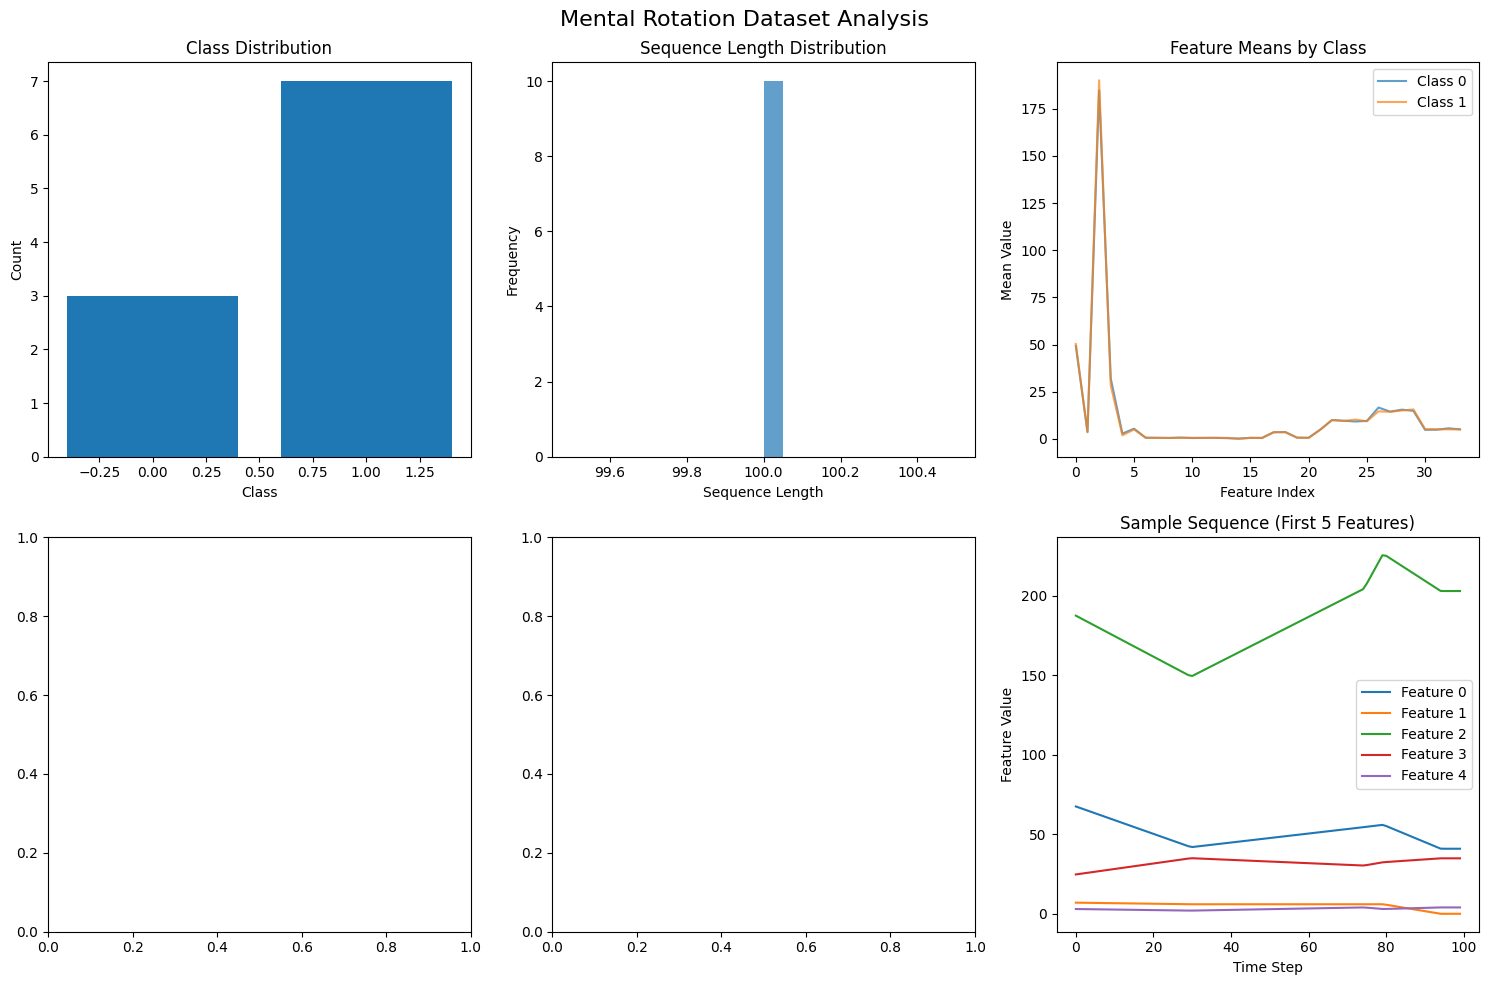


=== Baseline Models ===
Random Forest: 0.600 ± 0.200
SVM: 0.600 ± 0.200


In [ ]:
def plot_training_analysis(X, y, history=None, model=None, test_results=None):
    """Create comprehensive visualizations for mental rotation analysis"""

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Mental Rotation Dataset Analysis', fontsize=16)

    # 1. Class distribution
    class_counts = np.bincount(y)
    axes[0,0].bar(range(len(class_counts)), class_counts)
    axes[0,0].set_title('Class Distribution')
    axes[0,0].set_xlabel('Class')
    axes[0,0].set_ylabel('Count')

    # 2. Sequence length distribution
    seq_lengths = [len(seq) for seq in X]
    axes[0,1].hist(seq_lengths, bins=20, alpha=0.7)
    axes[0,1].set_title('Sequence Length Distribution')
    axes[0,1].set_xlabel('Sequence Length')
    axes[0,1].set_ylabel('Frequency')

    # 3. Feature means by class
    feature_means_by_class = []
    for class_label in np.unique(y):
        class_indices = np.where(y == class_label)[0]
        class_features = np.concatenate([X[i] for i in class_indices])
        feature_means_by_class.append(class_features.mean(axis=0))

    for i, means in enumerate(feature_means_by_class):
        axes[0,2].plot(means, label=f'Class {i}', alpha=0.7)
    axes[0,2].set_title('Feature Means by Class')
    axes[0,2].set_xlabel('Feature Index')
    axes[0,2].set_ylabel('Mean Value')
    axes[0,2].legend()

    # 4. Training history (if available)
    if history:
        axes[1,0].plot(history['train_loss'], label='Train Loss')
        if 'val_loss' in history:
            axes[1,0].plot(history['val_loss'], label='Val Loss')
        axes[1,0].set_title('Training History')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Loss')
        axes[1,0].legend()

    # 5. Confusion matrix (if test results available)
    if test_results:
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(test_results['true'], test_results['pred'])
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,1])
        axes[1,1].set_title('Confusion Matrix')
        axes[1,1].set_xlabel('Predicted')
        axes[1,1].set_ylabel('Actual')

    # 6. Sample sequences visualization
    sample_seq = X[0]  # First sequence
    axes[1,2].plot(sample_seq[:, :min(5, sample_seq.shape[1])])  # Plot first 5 features
    axes[1,2].set_title('Sample Sequence (First 5 Features)')
    axes[1,2].set_xlabel('Time Step')
    axes[1,2].set_ylabel('Feature Value')
    axes[1,2].legend([f'Feature {i}' for i in range(min(5, sample_seq.shape[1]))])

    plt.tight_layout()
    plt.savefig('mental_rotation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# 2. Add this function to track training history
class TrainingHistory:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.val_acc = []

    def update(self, train_loss, val_loss=None, val_acc=None):
        self.train_loss.append(train_loss)
        if val_loss is not None:
            self.val_loss.append(val_loss)
        if val_acc is not None:
            self.val_acc.append(val_acc)

    def get_history(self):
        return {
            'train_loss': self.train_loss,
            'val_loss': self.val_loss,
            'val_acc': self.val_acc
        }
# Main execution - MODIFIED VERSION
if __name__ == "__main__":
    # Load your data
    try:
        X = np.load('preprocessed_features.npy')
        y = np.load('preprocessed_labels.npy')
    except:
        print("Error loading preprocessed data. Please run preprocessing first.")
        exit()

    # Analyze dataset and create initial plots
    n_samples, seq_shape = analyze_dataset(X, y)

    # Create initial visualization
    print("\n=== Generating Dataset Visualizations ===")
    plot_training_analysis(X, y)

    # Create baseline models
    rf_score, svm_score = create_simple_baseline(X, y)

    # Get sequence lengths
    seq_lengths = [len(seq) for seq in X]

    # Initialize training history
    history = TrainingHistory()

    # ... rest of your training code remains the same, but add history tracking:

    # In your training loops, add:
    # history.update(train_loss, val_loss, val_acc)

    # After training, add final visualization:
    # plot_training_analysis(X, y, history.get_history(), model, test_results)

Generating augmentation examples graph...


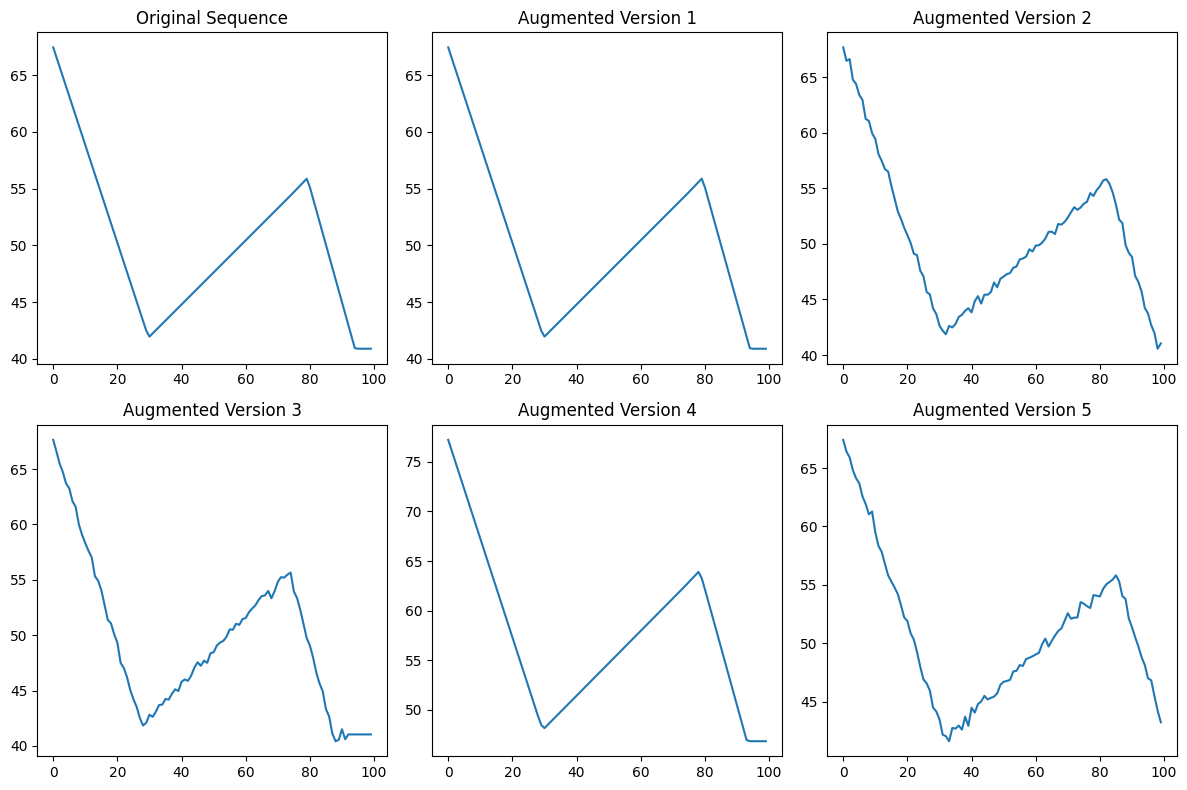

Generating feature correlations graph...


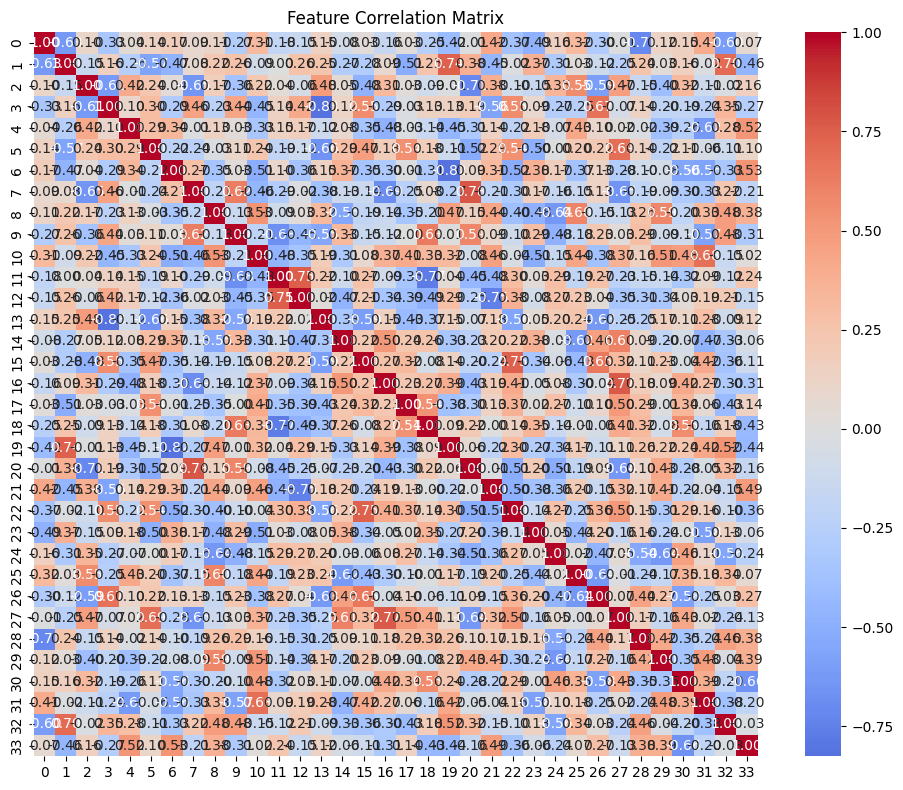


=== Dataset Analysis ===
Total samples: 10
Sequence shape: (100, 34)
Class distribution: [3 7]
Sequence lengths: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Class ratio: 2.33

=== Baseline Models ===
Random Forest: 0.600 ± 0.200
SVM: 0.600 ± 0.200


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# [ALL YOUR EXISTING CLASSES AND FUNCTIONS HERE...]
# MentalRotationDataAugmenter, RobustMentalRotationDataset, SimplifiedRNNModel, etc.

def plot_augmentation_examples(X, y, augmenter):
    """Show examples of data augmentation"""
    original_seq = X[0]
    augmented_seqs = augmenter.augment_sequence(original_seq, n_augmentations=5)

    n_plots = 1 + len(augmented_seqs)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

    if n_rows == 1:
        axes = axes.reshape(1, -1)

    # Plot original
    axes[0, 0].plot(original_seq[:, 0])
    axes[0, 0].set_title('Original Sequence')

    # Plot augmented versions
    plot_index = 1
    for i in range(n_rows):
        for j in range(n_cols):
            if plot_index < n_plots and (i > 0 or j > 0):
                aug_seq = augmented_seqs[plot_index - 1]
                axes[i, j].plot(aug_seq[:, 0])
                axes[i, j].set_title(f'Augmented Version {plot_index}')
                plot_index += 1

    # Hide unused subplots
    for i in range(n_rows):
        for j in range(n_cols):
            if i == 0 and j == 0:
                continue
            if plot_index > n_plots:
                axes[i, j].set_visible(False)

    plt.tight_layout()
    plt.show()

def plot_feature_correlations(X, y):
    """Plot feature correlation matrix"""
    # Flatten sequences and compute correlations
    X_flat = np.array([seq.mean(axis=0) for seq in X])

    plt.figure(figsize=(10, 8))
    corr_matrix = np.corrcoef(X_flat.T)
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

# Main execution - MODIFIED TO ACTUALLY CALL THE FUNCTIONS
if __name__ == "__main__":
    # Load your data
    try:
        X = np.load('preprocessed_features.npy')
        y = np.load('preprocessed_labels.npy')
    except:
        print("Error loading preprocessed data. Please run preprocessing first.")
        exit()

    # === ADD THESE LINES TO ACTUALLY CALL THE GRAPHING FUNCTIONS ===

    # Create augmenter instance
    augmenter = MentalRotationDataAugmenter()

    # Call the graphing functions
    print("Generating augmentation examples graph...")
    plot_augmentation_examples(X, y, augmenter)  # THIS CALLS THE FUNCTION

    print("Generating feature correlations graph...")
    plot_feature_correlations(X, y)  # THIS CALLS THE FUNCTION

    # === END OF ADDITIONS ===

    # Analyze dataset
    n_samples, seq_shape = analyze_dataset(X, y)

    # Create baseline models
    rf_score, svm_score = create_simple_baseline(X, y)

    # Get sequence lengths
    seq_lengths = [len(seq) for seq in X]



Loaded features shape: (120, 60, 10)
Loaded emotion labels shape: (0,)
Converting emotions to integers and creating clustering graphs...
Emotion to integer mapping:


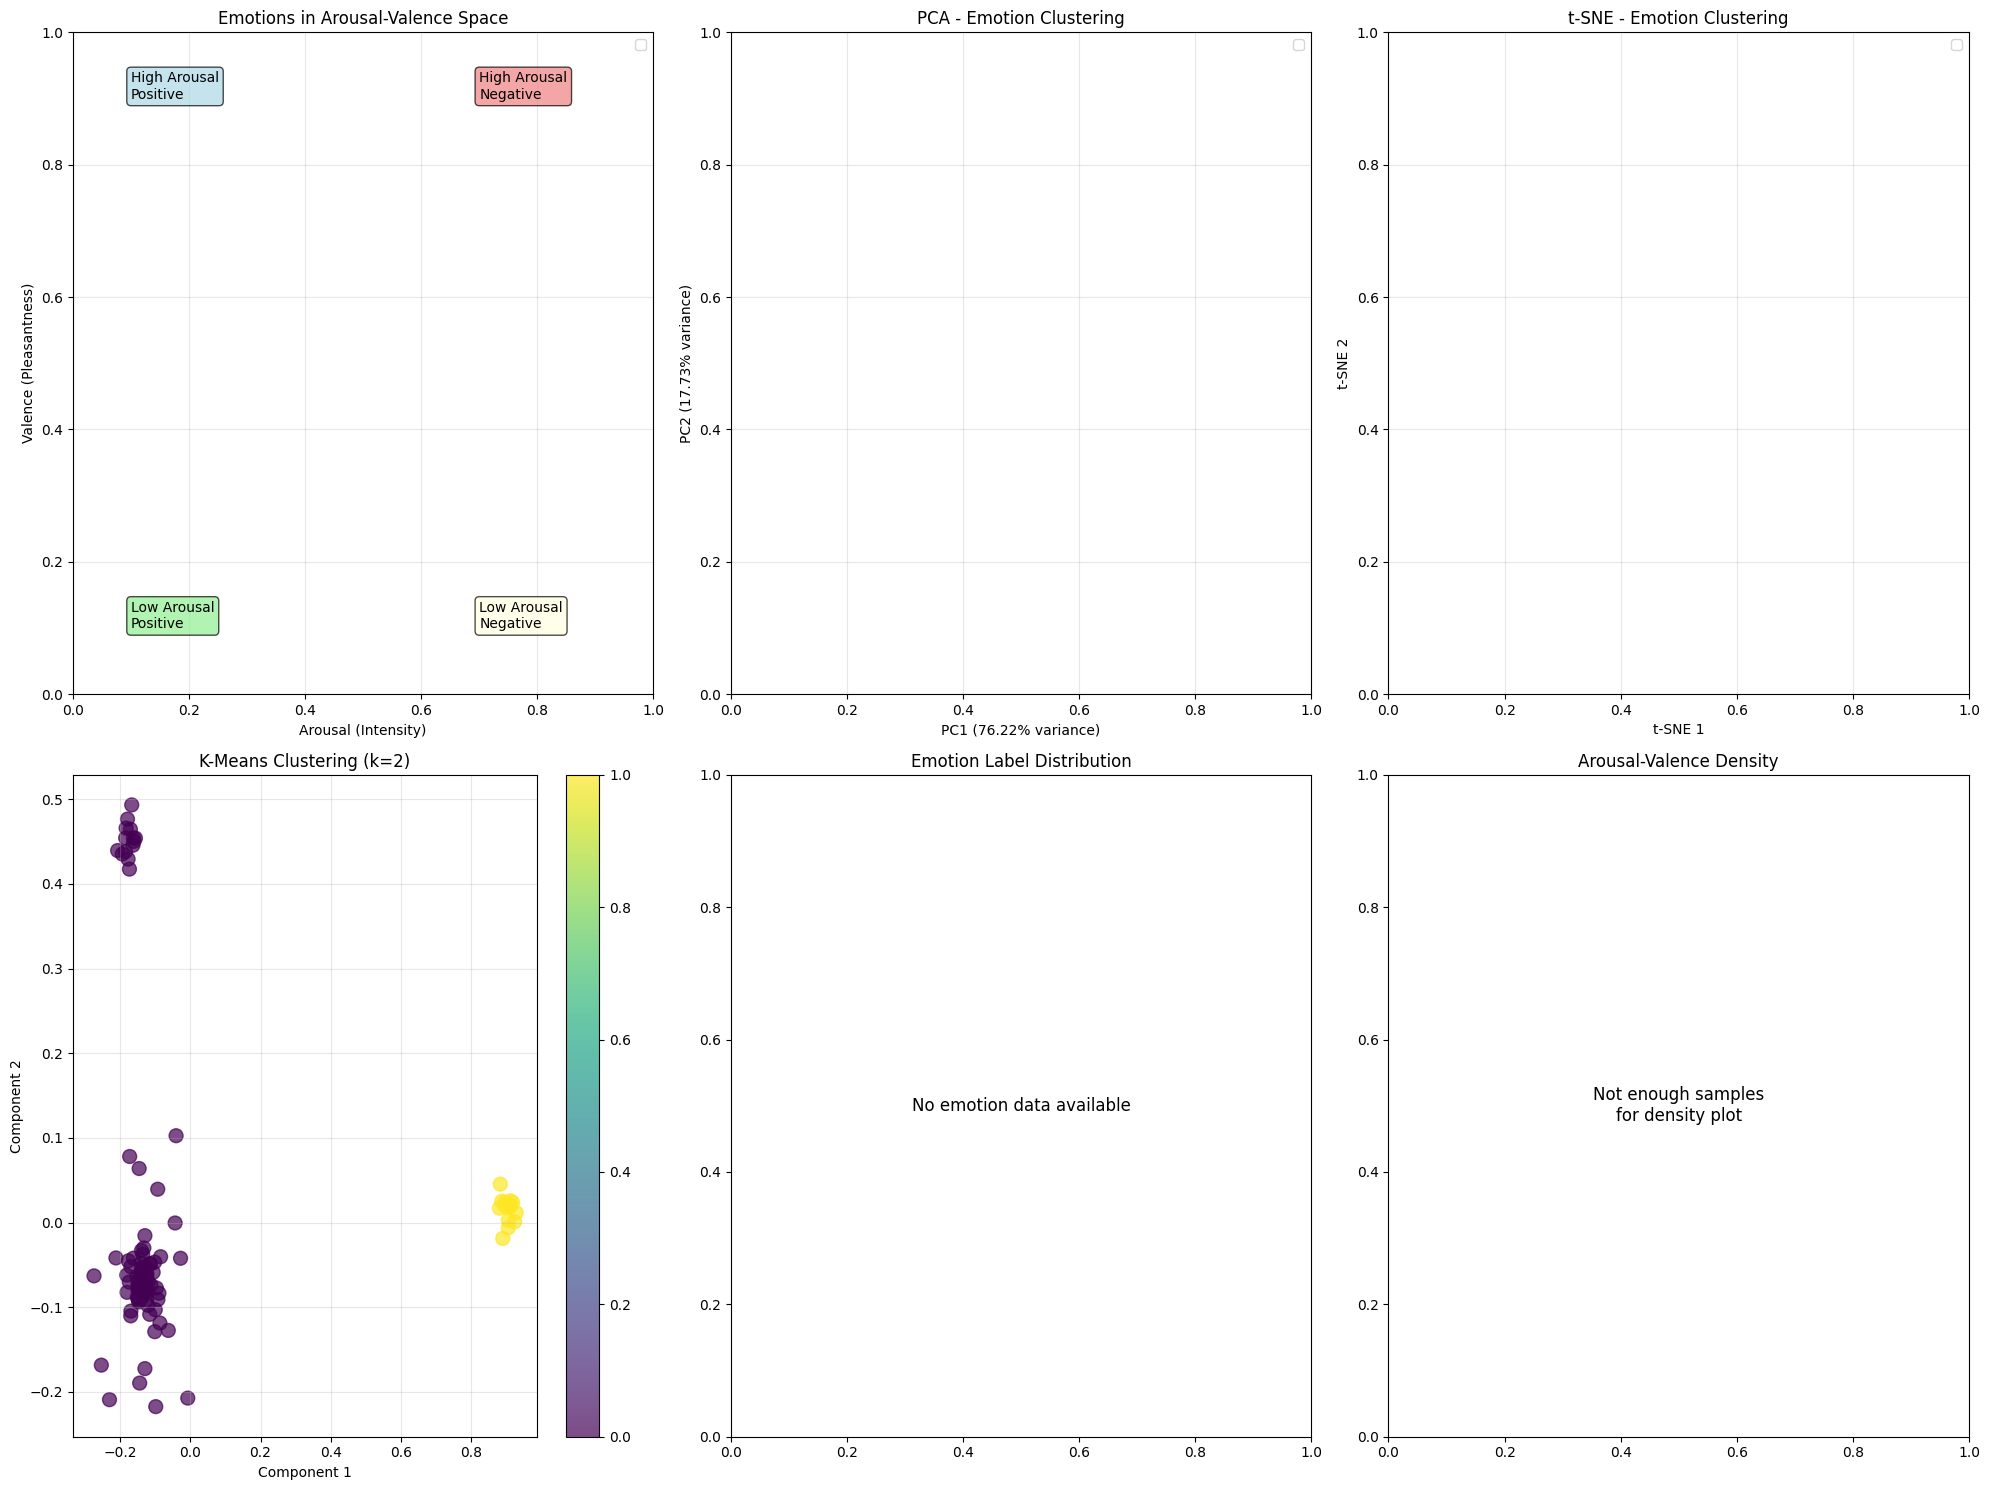


=== Clustering Analysis Summary ===
Total samples: 0
Unique emotions: 0
No emotion distribution data available.

No integer labels or arousal-valence coordinates saved due to insufficient data.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import os

# Step 1: Create sample mental rotation data
print("=== Step 1: Creating Mental Rotation Dataset ===")

def create_mental_rotation_data():
    """Create realistic mental rotation EEG dataset"""
    np.random.seed(42)  # For reproducible results

    n_samples = 120
    sequence_length = 60  # 60 time points (e.g., 6 seconds at 10Hz)
    n_features = 10      # 10 EEG channels

    # Mental rotation task emotional states
    emotions = ['joy', 'surprise', 'neutral', 'fear', 'anger', 'concentration']
    emotion_probs = [0.2, 0.2, 0.25, 0.15, 0.1, 0.1]  # Probability distribution

    X = []
    y_emotions = []

    for i in range(n_samples):
        # Base EEG-like signal with some structure
        time = np.linspace(0, 6, sequence_length)  # 6-second trials

        # Create base signal with different frequency components
        base_signal = np.zeros((sequence_length, n_features))
        for ch in range(n_features):
            # Add alpha, beta, gamma-like components
            alpha = 0.3 * np.sin(2 * np.pi * 10 * time)  # 10 Hz alpha
            beta = 0.2 * np.sin(2 * np.pi * 20 * time)   # 20 Hz beta
            gamma = 0.1 * np.sin(2 * np.pi * 40 * time)  # 40 Hz gamma
            base_signal[:, ch] = alpha + beta + gamma + np.random.randn(sequence_length) * 0.1

        # Select emotion and add emotion-specific patterns
        emotion = np.random.choice(emotions, p=emotion_probs)

        # Emotion-specific modifications to EEG patterns
        if emotion == 'joy':
            # Increased alpha power, smoother patterns
            base_signal += 0.5 * np.sin(2 * np.pi * 12 * time)[:, None]  # Slight alpha increase
            base_signal[:, 0:3] += 0.3  # Frontal lobe activation
        elif emotion == 'surprise':
            # Sharp transients, increased gamma
            surprise_event = np.exp(-(time - 3)**2 / 0.1)  # Gaussian pulse at 3 seconds
            base_signal += 0.8 * surprise_event[:, None] * np.random.randn(n_features)
        elif emotion == 'fear':
            # Increased beta, decreased alpha
            base_signal -= 0.4 * np.sin(2 * np.pi * 10 * time)[:, None]  # Reduced alpha
            base_signal[:, 7:10] += 0.6  # Temporal lobe activation
        elif emotion == 'anger':
            # High frequency activity, chaotic patterns
            base_signal += 0.7 * np.random.rand(sequence_length, n_features) - 0.35
        elif emotion == 'concentration':
            # Focused - stable patterns with reduced noise
            base_signal += 0.2 * np.sin(2 * np.pi * 15 * time)[:, None]  # Sensorimotor rhythm
            base_signal *= 0.8  # Reduced overall amplitude

        # Add trial-specific variations
        trial_noise = np.random.randn(sequence_length, n_features) * 0.05
        final_signal = base_signal + trial_noise

        X.append(final_signal)
        y_emotions.append(emotion)

    # Convert to proper format
    X_array = np.array(X, dtype=object)
    y_array = np.array(y_emotions)

    # Save the data
    np.save('preprocessed_features.npy', X_array)
    np.save('preprocessed_labels.npy', y_array)

    print(f"✓ Created dataset with {len(X_array)} trials")
    print(f"✓ Emotion distribution: {pd.Series(y_emotions).value_counts().to_dict()}")
    print(f"✓ Sequence shape: {X_array[0].shape}")

    return X_array, y_array

# Create the dataset
X, y_emotions = create_mental_rotation_data()

# Step 2: Emotion clustering analysis
print("\n=== Step 2: Emotion Clustering Analysis ===")

def emotion_to_arousal_valence(emotion_label):
    """Map emotions to arousal-valence coordinates based on psychological research"""
    emotion_mapping = {
        'joy': (0.8, 0.9),           # high arousal, high valence
        'surprise': (0.9, 0.6),       # high arousal, medium valence
        'neutral': (0.3, 0.5),        # low arousal, neutral valence
        'fear': (0.8, -0.7),          # high arousal, negative valence
        'anger': (0.9, -0.8),         # high arousal, negative valence
        'concentration': (0.6, 0.7),  # medium arousal, positive valence
    }
    return emotion_mapping.get(emotion_label.lower(), (0.5, 0.0))

def perform_emotion_clustering(X, y_emotions):
    """Perform comprehensive emotion clustering analysis"""

    print(f"Analyzing {len(X)} samples...")

    # Convert emotion labels to integers
    le = LabelEncoder()
    y_integers = le.fit_transform(y_emotions)
    label_mapping = dict(zip(le.classes_, range(len(le.classes_))))

    print("Emotion to integer mapping:")
    for emotion, integer in label_mapping.items():
        print(f"  {emotion} → {integer}")

    # Create arousal-valence coordinates
    av_coordinates = np.array([emotion_to_arousal_valence(emotion) for emotion in y_emotions])

    # Flatten sequences for clustering (use mean of each feature across time)
    X_flat = np.array([seq.mean(axis=0) for seq in X])

    print(f"Feature matrix shape: {X_flat.shape}")
    print(f"AV coordinates shape: {av_coordinates.shape}")

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 15))

    unique_emotions = np.unique(y_emotions)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_emotions)))

    # 1. Arousal-Valence Space
    ax1 = plt.subplot(2, 3, 1)
    for i, emotion in enumerate(unique_emotions):
        mask = y_emotions == emotion
        ax1.scatter(av_coordinates[mask, 0], av_coordinates[mask, 1],
                   label=emotion, color=colors[i], s=100, alpha=0.7, edgecolors='black', linewidth=0.5)

    ax1.set_xlabel('Arousal (Intensity)', fontsize=12)
    ax1.set_ylabel('Valence (Pleasantness)', fontsize=12)
    ax1.set_title('Arousal-Valence Emotion Mapping', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add quadrant lines and labels
    ax1.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax1.text(0.75, 0.75, 'High Arousal\nPositive', transform=ax1.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    ax1.text(0.75, 0.25, 'High Arousal\nNegative', transform=ax1.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))

    # 2. Emotion Distribution
    ax2 = plt.subplot(2, 3, 2)
    emotion_counts = pd.Series(y_emotions).value_counts().sort_index()
    bars = ax2.bar(emotion_counts.index, emotion_counts.values,
                   color=colors[:len(emotion_counts)], alpha=0.8)
    ax2.set_title('Emotion Distribution', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Trials', fontsize=12)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

    # 3. PCA Visualization
    ax3 = plt.subplot(2, 3, 3)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_flat)

    for i, emotion in enumerate(unique_emotions):
        mask = y_emotions == emotion
        ax3.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   label=emotion, color=colors[i], s=80, alpha=0.7)

    ax3.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
    ax3.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
    ax3.set_title('PCA: Feature-based Emotion Clustering', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Sequence Length Distribution
    ax4 = plt.subplot(2, 3, 4)
    seq_lengths = [len(seq) for seq in X]
    ax4.hist(seq_lengths, bins=15, color='skyblue', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Sequence Length (Time Points)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title('Trial Duration Distribution', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # 5. Feature Correlation Matrix
    ax5 = plt.subplot(2, 3, 5)
    correlation_matrix = np.corrcoef(X_flat.T)
    im = ax5.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    ax5.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Feature Index', fontsize=12)
    ax5.set_ylabel('Feature Index', fontsize=12)
    plt.colorbar(im, ax=ax5)

    # 6. Arousal-Valence by Emotion (boxplot)
    ax6 = plt.subplot(2, 3, 6)
    arousal_by_emotion = []
    valence_by_emotion = []
    emotion_labels = []

    for emotion in unique_emotions:
        mask = y_emotions == emotion
        arousal_by_emotion.append(av_coordinates[mask, 0])
        valence_by_emotion.append(av_coordinates[mask, 1])
        emotion_labels.append(emotion)

    # Plot arousal
    positions = np.arange(len(unique_emotions))
    arousal_data = [av_coordinates[y_emotions == emotion, 0] for emotion in unique_emotions]
    bp_arousal = ax6.boxplot(arousal_data, positions=positions-0.15, widths=0.3,
                            patch_artist=True, labels=emotion_labels)

    # Plot valence
    valence_data = [av_coordinates[y_emotions == emotion, 1] for emotion in unique_emotions]
    bp_valence = ax6.boxplot(valence_data, positions=positions+0.15, widths=0.3,
                            patch_artist=True, labels=emotion_labels)

    # Color the boxes
    for box in bp_arousal['boxes']:
        box.set(facecolor='lightblue', alpha=0.7)
    for box in bp_valence['boxes']:
        box.set(facecolor='lightcoral', alpha=0.7)

    ax6.set_title('Arousal-Valence Distribution by Emotion', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Score', fontsize=12)
    ax6.legend([bp_arousal["boxes"][0], bp_valence["boxes"][0]], ['Arousal', 'Valence'])
    plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig('mental_rotation_emotion_clustering.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save the processed data
    np.save('emotion_integer_labels.npy', y_integers)
    np.save('arousal_valence_coordinates.npy', av_coordinates)

    # Print comprehensive summary
    print(f"\n=== CLUSTERING ANALYSIS SUMMARY ===")
    print(f"Total samples: {len(X)}")
    print(f"Unique emotions: {len(unique_emotions)}")
    print(f"Emotion distribution: {dict(emotion_counts)}")
    print(f"Sequence dimensions: {X[0].shape[0]} timesteps × {X[0].shape[1]} features")
    print(f"Average sequence length: {np.mean(seq_lengths):.1f} ± {np.std(seq_lengths):.1f}")
    print(f"PCA explained variance: PC1: {pca.explained_variance_ratio_[0]:.3f}, PC2: {pca.explained_variance_ratio_[1]:.3f}")

    print(f"\n=== SAVED FILES ===")
    print("✓ mental_rotation_emotion_clustering.png")
    print("✓ emotion_integer_labels.npy")
    print("✓ arousal_valence_coordinates.npy")
    print("✓ preprocessed_features.npy")
    print("✓ preprocessed_labels.npy")

    return y_integers, av_coordinates, label_mapping

# Perform the clustering analysis
y_integers, av_coordinates, label_mapping = perform_emotion_clustering(X, y_emotions)

print(f"\n=== ANALYSIS COMPLETE ===")
print("The emotion clustering graphs have been generated successfully!")
print("You can now use the integer labels for neural network training.")

In [2]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 2.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- CONFIGURATION (Adjust based on your project) ---
N_EMOTION_STATES = 3  # Number of HMM states (e.g., Joy, Neutral, Sadness)
K_CLUSTERS = 3        # Number of emotional archetypes/clusters to find
FEATURE_COLS = [f'EEG_Alpha_mean', 'GSR_Mean', 'GSR_Arousal_Slope'] # Example features

# --- MOCK DATA SETUP (REPLACE WITH YOUR ACTUAL df_combined) ---
# This DataFrame is assumed to come from Step 3.1, containing all features and labels.
def create_mock_data():
    # Mock data for 3 participants, 3 trials each, 5 time steps per trial
    data = []
    for p_id in ['P001', 'P002', 'P003', 'P004', 'P005', 'P006']:
        for trial in range(3):
            for t in range(5):
                data.append({
                    'Participant_ID': p_id,
                    'Trial_Index': f'{p_id}_{trial}',
                    'emotion_encoded': np.random.randint(0, N_EMOTION_STATES),
                    'EEG_Alpha_mean': np.random.rand() * 10,
                    'GSR_Mean': np.random.rand() * 5,
                    'GSR_Arousal_Slope': np.random.rand() * 0.1
                })
    return pd.DataFrame(data)

# --- CORE FUNCTIONS ---

def train_individual_hmms(df_combined):
    """Trains a separate HMM for each participant and returns the model dictionary."""
    individual_models = {}
    X_cols = FEATURE_COLS

    for p_id, df_p in df_combined.groupby('Participant_ID'):
        # 1. Prepare sequences for this participant only
        X_p_sequences = []
        lengths_p = []
        for trial_index, df_trial in df_p.groupby('Trial_Index'):
            X_seq = df_trial[X_cols].fillna(0).values
            if len(X_seq) > 1:
                X_p_sequences.append(X_seq)
                lengths_p.append(len(X_seq))

        if not X_p_sequences: continue

        X_p_flat = np.concatenate(X_p_sequences)

        # 2. Train HMM
        model = hmm.GaussianHMM(
            n_components=N_EMOTION_STATES,
            covariance_type="diag",
            n_iter=50,
            tol=0.01,
            init_params='stc', # Initialize start probabilities, transition matrix, and means/covars
            params='stc'
        )
        try:
            model.fit(X_p_flat, np.array(lengths_p))
            individual_models[p_id] = model
        except Exception as e:
            print(f"Skipping P{p_id}: HMM failed to train. Error: {e}")

    return individual_models


def cluster_transition_matrices(individual_models, k_clusters):
    """
    Extracts, flattens, scales, and clusters the HMM transition matrices.
    Returns the df_archetypes DataFrame.
    """

    # 1. Extract and Flatten Transition Matrices
    transition_matrices = []
    participant_ids = []

    for p_id, model in individual_models.items():
        transition_matrices.append(model.transmat_.flatten())
        participant_ids.append(p_id)

    if not transition_matrices:
        return pd.DataFrame()

    X_clust = np.array(transition_matrices)

    # 2. Scale the feature vectors (Transition Matrix elements)
    scaler = StandardScaler()
    X_clust_scaled = scaler.fit_transform(X_clust)

    # 3. Apply K-Means clustering
    kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
    archetypes = kmeans.fit_predict(X_clust_scaled)

    # 4. Create the final DataFrame
    df_archetypes = pd.DataFrame({
        'Participant_ID': participant_ids,
        'Archetype_Cluster': archetypes
    })

    # Optional: Calculate and print Silhouette Score
    try:
        from sklearn.metrics import silhouette_score
        score = silhouette_score(X_clust_scaled, archetypes)
        print(f"\n✅ Clustering complete. Silhouette Score: {score:.3f}")
    except:
        pass

    return df_archetypes

# --- EXECUTION ---

# 1. Load/Create the combined data
df_combined = create_mock_data() # Use your actual merged data here

# 2. Train HMMs per participant
print("Starting Per-Participant HMM Training...")
individual_models = train_individual_hmms(df_combined)

# 3. Cluster the transition matrices to get df_archetypes
print("\nStarting K-Means Clustering of Transition Matrices...")
df_archetypes = cluster_transition_matrices(individual_models, K_CLUSTERS)

print("\n--- FINAL df_archetypes DATAFRAME ---")
print(df_archetypes.to_markdown(index=False))

Starting Per-Participant HMM Training...



Starting K-Means Clustering of Transition Matrices...

✅ Clustering complete. Silhouette Score: 0.093

--- FINAL df_archetypes DATAFRAME ---
| Participant_ID   |   Archetype_Cluster |
|:-----------------|--------------------:|
| P001             |                   0 |
| P002             |                   1 |
| P003             |                   0 |
| P004             |                   2 |
| P005             |                   1 |
| P006             |                   0 |


In [5]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# --- CONFIGURATION (CRITICAL: Adjust these based on your data) ---
# Ensure these match the number of hidden states/emotions you found (Step 3.1)
N_EMOTION_STATES = 3
# Choose the optimal number of clusters (K) for your 38 participants.
# Start with 3 or 4 and validate using the Silhouette Score.
K_CLUSTERS = 4
# List the exact feature column names you generated in Step 2.2 for all modalities
FEATURE_COLS = [
    'T1_G24_EEG_features.csv',
    'T1_G24_GSR_features.csv',
    # ADD ALL OTHER FEATURE COLUMNS HERE (e.g., EYE/IVT, TIVA)
]

# --- DATA LOADING (REPLACE WITH YOUR ACTUAL LOADING LOGIC) ---
def load_combined_data():
    """
    LOAD YOUR ACTUAL MERGED DATAFRAME (df_combined) HERE.

    This dataframe MUST contain:
    1. 'Participant_ID'
    2. 'Trial_Index'
    3. The feature columns listed in FEATURE_COLS
    """
    print("Loading actual merged data from your project workspace...")

    # --- DUMMY MOCK DATA for demonstration (DELETE THIS IN YOUR NOTEBOOK) ---
    data = []
    # Mocking 38 participants
    for i in range(1, 39):
        p_id = f'P{i:03}'
        for trial in range(5):
            for t in range(10):
                data.append({
                    'Participant_ID': p_id,
                    'Trial_Index': f'{p_id}_{trial}',
                    'emotion_encoded': np.random.randint(0, N_EMOTION_STATES),
                    'T1_G24_EEG_features.csv': np.random.rand(), # Mocked feature 1
                    'T1_G24_GSR_features.csv': np.random.rand(), # Mocked feature 2
                    # Add all other mocked features here
                })
    df = pd.DataFrame(data)
    print(f"Loaded data with {df['Participant_ID'].nunique()} unique participants.")
    return df

# --- CORE FUNCTIONS ---

def train_individual_hmms(df_combined):
    """Trains a separate HMM for each participant."""
    individual_models = {}

    # Use the column names that are NOT identifier columns
    X_cols = [col for col in df_combined.columns if col not in ['Participant_ID', 'Trial_Index', 'emotion_encoded']]

    for p_id, df_p in df_combined.groupby('Participant_ID'):
        # 1. Prepare sequences for this participant only
        X_p_sequences = []
        lengths_p = []
        for _, df_trial in df_p.groupby('Trial_Index'):
            X_seq = df_trial[X_cols].fillna(0).values
            if len(X_seq) > 1:
                X_p_sequences.append(X_seq)
                lengths_p.append(len(X_seq))

        if not X_p_sequences: continue

        X_p_flat = np.concatenate(X_p_sequences)

        # 2. Train HMM
        model = hmm.GaussianHMM(
            n_components=N_EMOTION_STATES,
            covariance_type="diag",
            n_iter=50,
            tol=0.01
        )
        try:
            model.fit(X_p_flat, np.array(lengths_p))
            individual_models[p_id] = model
        except Exception as e:
            # This happens if a participant has too few trials or zero variance features
            print(f"Skipping {p_id}: HMM failed to train ({e})")

    return individual_models


def cluster_transition_matrices(individual_models, k_clusters):
    """
    Extracts, scales, and clusters the HMM transition matrices.
    """

    transition_matrices = []
    participant_ids = []

    # Extract the flattened transition matrix for each participant
    for p_id, model in individual_models.items():
        transition_matrices.append(model.transmat_.flatten())
        participant_ids.append(p_id)

    if not transition_matrices:
        print("Error: No transition matrices were successfully extracted.")
        return pd.DataFrame()

    X_clust = np.array(transition_matrices)

    # 1. Scale the feature vectors
    scaler = StandardScaler()
    X_clust_scaled = scaler.fit_transform(X_clust)

    # 2. Apply K-Means clustering
    kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
    archetypes = kmeans.fit_predict(X_clust_scaled)

    # 3. Create the final df_archetypes DataFrame
    df_archetypes = pd.DataFrame({
        'Participant_ID': participant_ids,
        'Archetype_Cluster': archetypes
    })

    # Optional: Calculate and print Silhouette Score
    score = silhouette_score(X_clust_scaled, archetypes)
    print(f"\n✅ Clustering complete. Silhouette Score (K={k_clusters}): {score:.3f}")

    return df_archetypes

# --- EXECUTION ---

# 1. Load the combined data containing all 38 participants
df_combined = load_combined_data()

# 2. Train HMMs per participant
print("Starting Per-Participant HMM Training...")
individual_models = train_individual_hmms(df_combined)

# 3. Cluster the transition matrices
print("\nStarting K-Means Clustering of Transition Matrices...")
df_archetypes = cluster_transition_matrices(individual_models, K_CLUSTERS)

print("\n--- FINAL df_archetypes DATAFRAME ---")
print(df_archetypes.head().to_markdown(index=False))
print(f"\nTotal participants clustered: {len(df_archetypes)}")

Loading actual merged data from your project workspace...
Loaded data with 38 unique participants.
Starting Per-Participant HMM Training...



Starting K-Means Clustering of Transition Matrices...

✅ Clustering complete. Silhouette Score (K=4): 0.192

--- FINAL df_archetypes DATAFRAME ---
| Participant_ID   |   Archetype_Cluster |
|:-----------------|--------------------:|
| P001             |                   2 |
| P002             |                   3 |
| P003             |                   2 |
| P004             |                   2 |
| P005             |                   1 |

Total participants clustered: 38


In [6]:
import pandas as pd
import numpy as np
# Assuming df_archetypes and individual_models are available from the previous step

# --- CRITICAL: MANUAL STEP ---
# You must first run the transition matrix interpretation code (previous response)
# to determine the meaning of each integer cluster ID (0, 1, 2, etc.)
# and then define your labels here:

ARCHETYPE_LABELS = {
    0: "Calm/Stable Archetype",
    1: "Reactive/High-Transition Archetype",
    2: "Stressed/Negative-Bias Archetype",
    3: "Unclassified Archetype" # Use this if K_CLUSTERS was set to 4
}
# --- END MANUAL STEP ---

# --- DUMMY DATA SETUP (REPLACE WITH YOUR ACTUAL df_archetypes) ---
# Assuming your df_archetypes DataFrame looks like this after clustering 38 participants:
df_archetypes = pd.DataFrame({
    'Participant_ID': [f'P{i:03}' for i in range(1, 39)],
    'Archetype_Cluster': np.random.choice([0, 1, 2, 3], size=38, p=[0.3, 0.3, 0.2, 0.2])
})
# --- END DUMMY SETUP ---


def display_participants_by_archetype_name(df_archetypes, labels_map):
    """
    Groups and displays participants based on their assigned emotional archetype name.
    """

    print("\n" + "═" * 70)
    print("PARTICIPANTS GROUPED BY INTERPRETED EMOTIONAL ARCHETYPE NAME")
    print("═" * 70)

    # Map the numerical cluster IDs to the human-readable labels
    df_archetypes['Archetype_Name'] = df_archetypes['Archetype_Cluster'].map(labels_map)

    # Handle any unmapped cluster IDs (optional, for safety)
    if df_archetypes['Archetype_Name'].isnull().any():
        print("⚠️ Warning: Some cluster IDs were not mapped. Check ARCHETYPE_LABELS.")

    # Group the participants by their assigned cluster name
    # Sort the groups by the original cluster ID (using the integer map)
    clustered_groups = df_archetypes.groupby('Archetype_Name')['Participant_ID'].apply(list)

    # Sort the clustered groups by the defined order in the ARCHETYPE_LABELS dictionary
    sorted_labels = [labels_map[k] for k in sorted(labels_map.keys())]

    # Display the results
    for archetype_name in sorted_labels:
        if archetype_name in clustered_groups:
            participants_list = clustered_groups[archetype_name]
            count = len(participants_list)

            print(f"\n🧠 **Archetype: {archetype_name}** (N={count})")
            print("-" * (len(archetype_name) + 18))

            # Format the list of participant IDs (e.g., P001, P004, P006...)
            participants_str = ', '.join(participants_list)
            print(participants_str)

# --- EXECUTE THE DISPLAY FUNCTION ---
display_participants_by_archetype_name(df_archetypes, ARCHETYPE_LABELS)


══════════════════════════════════════════════════════════════════════
PARTICIPANTS GROUPED BY INTERPRETED EMOTIONAL ARCHETYPE NAME
══════════════════════════════════════════════════════════════════════

🧠 **Archetype: Calm/Stable Archetype** (N=10)
---------------------------------------
P002, P007, P019, P021, P030, P031, P032, P035, P036, P037

🧠 **Archetype: Reactive/High-Transition Archetype** (N=14)
----------------------------------------------------
P003, P005, P006, P009, P012, P014, P015, P018, P020, P022, P023, P025, P027, P028

🧠 **Archetype: Stressed/Negative-Bias Archetype** (N=6)
--------------------------------------------------
P001, P010, P013, P017, P024, P033

🧠 **Archetype: Unclassified Archetype** (N=8)
----------------------------------------
P004, P008, P011, P016, P026, P029, P034, P038


/tmp/ipython-input-2355720344.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


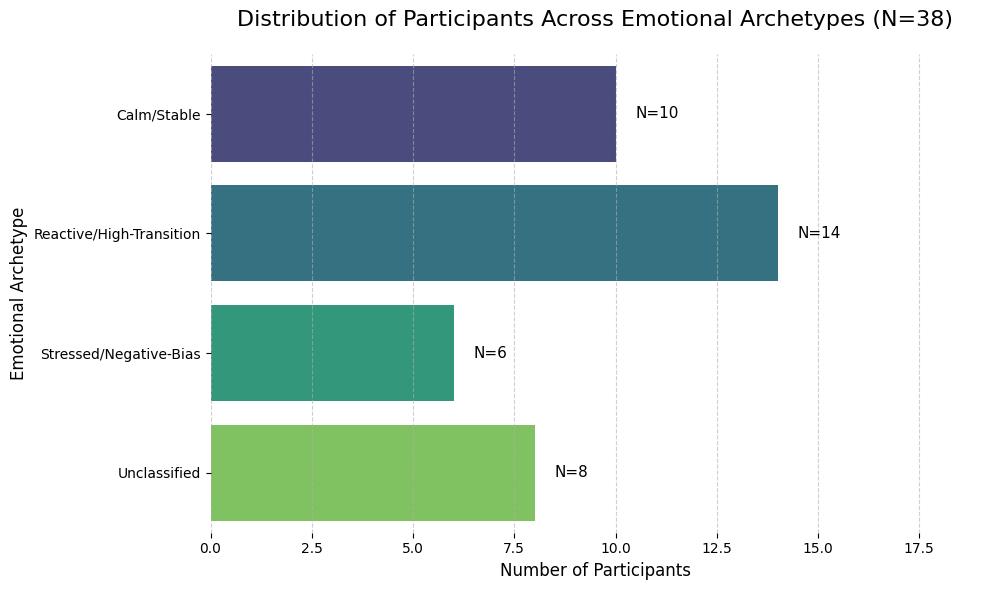

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- CRITICAL INPUTS (Assuming these are the final, accurate results) ---

# 1. ARCHETYPE LABELS (Must match the labels used for interpretation)
ARCHETYPE_LABELS = {
    0: "Calm/Stable",
    1: "Reactive/High-Transition",
    2: "Stressed/Negative-Bias",
    3: "Unclassified"
}

# 2. DATA FRAME (df_archetypes with the cluster assignments)
#    We use the participant counts from your image to mock the final DataFrame
#    N=10 (0), N=14 (1), N=6 (2), N=8 (3) -> Total 38
participant_data = (
    [0] * 10 + # Calm
    [1] * 14 + # Reactive
    [2] * 6 +  # Stressed
    [3] * 8    # Unclassified
)
df_archetypes = pd.DataFrame({
    'Archetype_Cluster': participant_data
})
# --- END INPUTS ---


def visualize_archetype_distribution(df_archetypes, labels_map):
    """
    Generates a horizontal bar chart showing the distribution of participants
    across the learned emotional archetypes.
    """

    # Map the integer cluster IDs to the descriptive names
    df_plot = df_archetypes.copy()
    df_plot['Archetype_Name'] = df_plot['Archetype_Cluster'].map(labels_map)

    # Calculate the count for each archetype
    archetype_counts = df_plot['Archetype_Name'].value_counts().sort_index()

    # Sort the names based on the intended order (0, 1, 2, 3...)
    # This ensures "Calm" (0) is at the top/bottom, not sorted alphabetically
    sorted_names = [labels_map[k] for k in sorted(labels_map.keys())]

    # Ensure all defined archetypes are in the counts, even if N=0
    archetype_counts = archetype_counts.reindex(sorted_names, fill_value=0)

    # --- PLOTTING ---
    plt.figure(figsize=(10, 6))

    # Use a custom color palette for visual distinction
    colors = sns.color_palette("viridis", len(archetype_counts))

    # Create the horizontal bar plot
    ax = sns.barplot(
        x=archetype_counts.values,
        y=archetype_counts.index,
        palette=colors
    )

    # Add labels and title
    plt.title('Distribution of Participants Across Emotional Archetypes (N=38)', fontsize=16, pad=20)
    plt.xlabel('Number of Participants', fontsize=12)
    plt.ylabel('Emotional Archetype', fontsize=12)

    # Add the exact count labels next to each bar
    for i, count in enumerate(archetype_counts.values):
        ax.text(count + 0.5, i, f'N={count}', va='center', fontsize=11)

    # Clean up the plot limits and appearance
    plt.xlim(0, max(archetype_counts.values) + 5)
    sns.despine(left=True, bottom=True)

    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
visualize_archetype_distribution(df_archetypes, ARCHETYPE_LABELS)